In [1]:
import pandas as pd
import random
import dask.dataframe as dd
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np



In [2]:
# ddf = dd.read_csv(timeseries_file_path)
# 
# # Randomly sample 1% of the dataset
# sample_ddf = ddf.sample(frac=0.01)
# 
# # Compute the sample, converting the Dask DataFrame to a Pandas DataFrame
# sample_df = sample_ddf.compute()
# 
# print(sample_df.head())

sample_df = dd.read_csv('/home/max/AxpoProjects/hackdays-2024/100_15_2021.csv').compute()
sample_df.head()

,id,timestamp,value_kwh,year
0,f75148515d279e2c6c36207fa4002faf,2021-05-08T00:15:00.000Z,0.0,2021
1,f75148515d279e2c6c36207fa4002faf,2021-01-30T06:30:00.000Z,0.0,2021
2,f75148515d279e2c6c36207fa4002faf,2021-01-25T23:15:00.000Z,0.0,2021
3,f75148515d279e2c6c36207fa4002faf,2021-02-03T18:30:00.000Z,0.0,2021
4,f75148515d279e2c6c36207fa4002faf,2021-06-17T19:15:00.000Z,0.0,2021


In [3]:
# Add month column
sample_df['timestamp'] = pd.to_datetime(sample_df['timestamp'])
sample_df['year_month'] = sample_df['timestamp'].dt.to_period('M')
sample_df.head()

/tmp/ipykernel_39518/1431073474.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sample_df['year_month'] = sample_df['timestamp'].dt.to_period('M')


,id,timestamp,value_kwh,year,year_month
0,f75148515d279e2c6c36207fa4002faf,2021-05-08 00:15:00+00:00,0.0,2021,2021-05
1,f75148515d279e2c6c36207fa4002faf,2021-01-30 06:30:00+00:00,0.0,2021,2021-01
2,f75148515d279e2c6c36207fa4002faf,2021-01-25 23:15:00+00:00,0.0,2021,2021-01
3,f75148515d279e2c6c36207fa4002faf,2021-02-03 18:30:00+00:00,0.0,2021,2021-02
4,f75148515d279e2c6c36207fa4002faf,2021-06-17 19:15:00+00:00,0.0,2021,2021-06


In [4]:
# Step 1: Group by 'id' and extract features
monthly_features_df = sample_df.groupby(['id', 'year_month']).agg({
    'value_kwh': ['mean', 'std', 'min', 'max']
})

monthly_features_df.columns = ['_'.join(col).strip() for col in monthly_features_df.columns.values]
monthly_features_df = monthly_features_df.reset_index()
monthly_features_df.head()

,id,year_month,value_kwh_mean,value_kwh_std,value_kwh_min,value_kwh_max
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0.050968,0.018580,0.0,0.095
1,035293b7f95ace18fc6c574cc4e6cc74,2021-02,0.046885,0.019188,0.0,0.097
2,035293b7f95ace18fc6c574cc4e6cc74,2021-03,0.045167,0.018714,0.0,0.095
3,035293b7f95ace18fc6c574cc4e6cc74,2021-04,0.042099,0.018532,0.0,0.096
4,035293b7f95ace18fc6c574cc4e6cc74,2021-05,0.037923,0.018846,0.0,0.095


In [5]:
n_clusters = 5

scaler = StandardScaler()
X_scaled = scaler.fit_transform(monthly_features_df.drop(columns=['id', 'year_month']))

kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, random_state=42)
kmeans.fit(X_scaled)

# Assign the cluster labels
monthly_features_df['cluster'] = kmeans.labels_
monthly_features_df.head()

,id,year_month,value_kwh_mean,value_kwh_std,value_kwh_min,value_kwh_max,cluster
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0.050968,0.018580,0.0,0.095,0
1,035293b7f95ace18fc6c574cc4e6cc74,2021-02,0.046885,0.019188,0.0,0.097,0
2,035293b7f95ace18fc6c574cc4e6cc74,2021-03,0.045167,0.018714,0.0,0.095,0
3,035293b7f95ace18fc6c574cc4e6cc74,2021-04,0.042099,0.018532,0.0,0.096,0
4,035293b7f95ace18fc6c574cc4e6cc74,2021-05,0.037923,0.018846,0.0,0.095,0


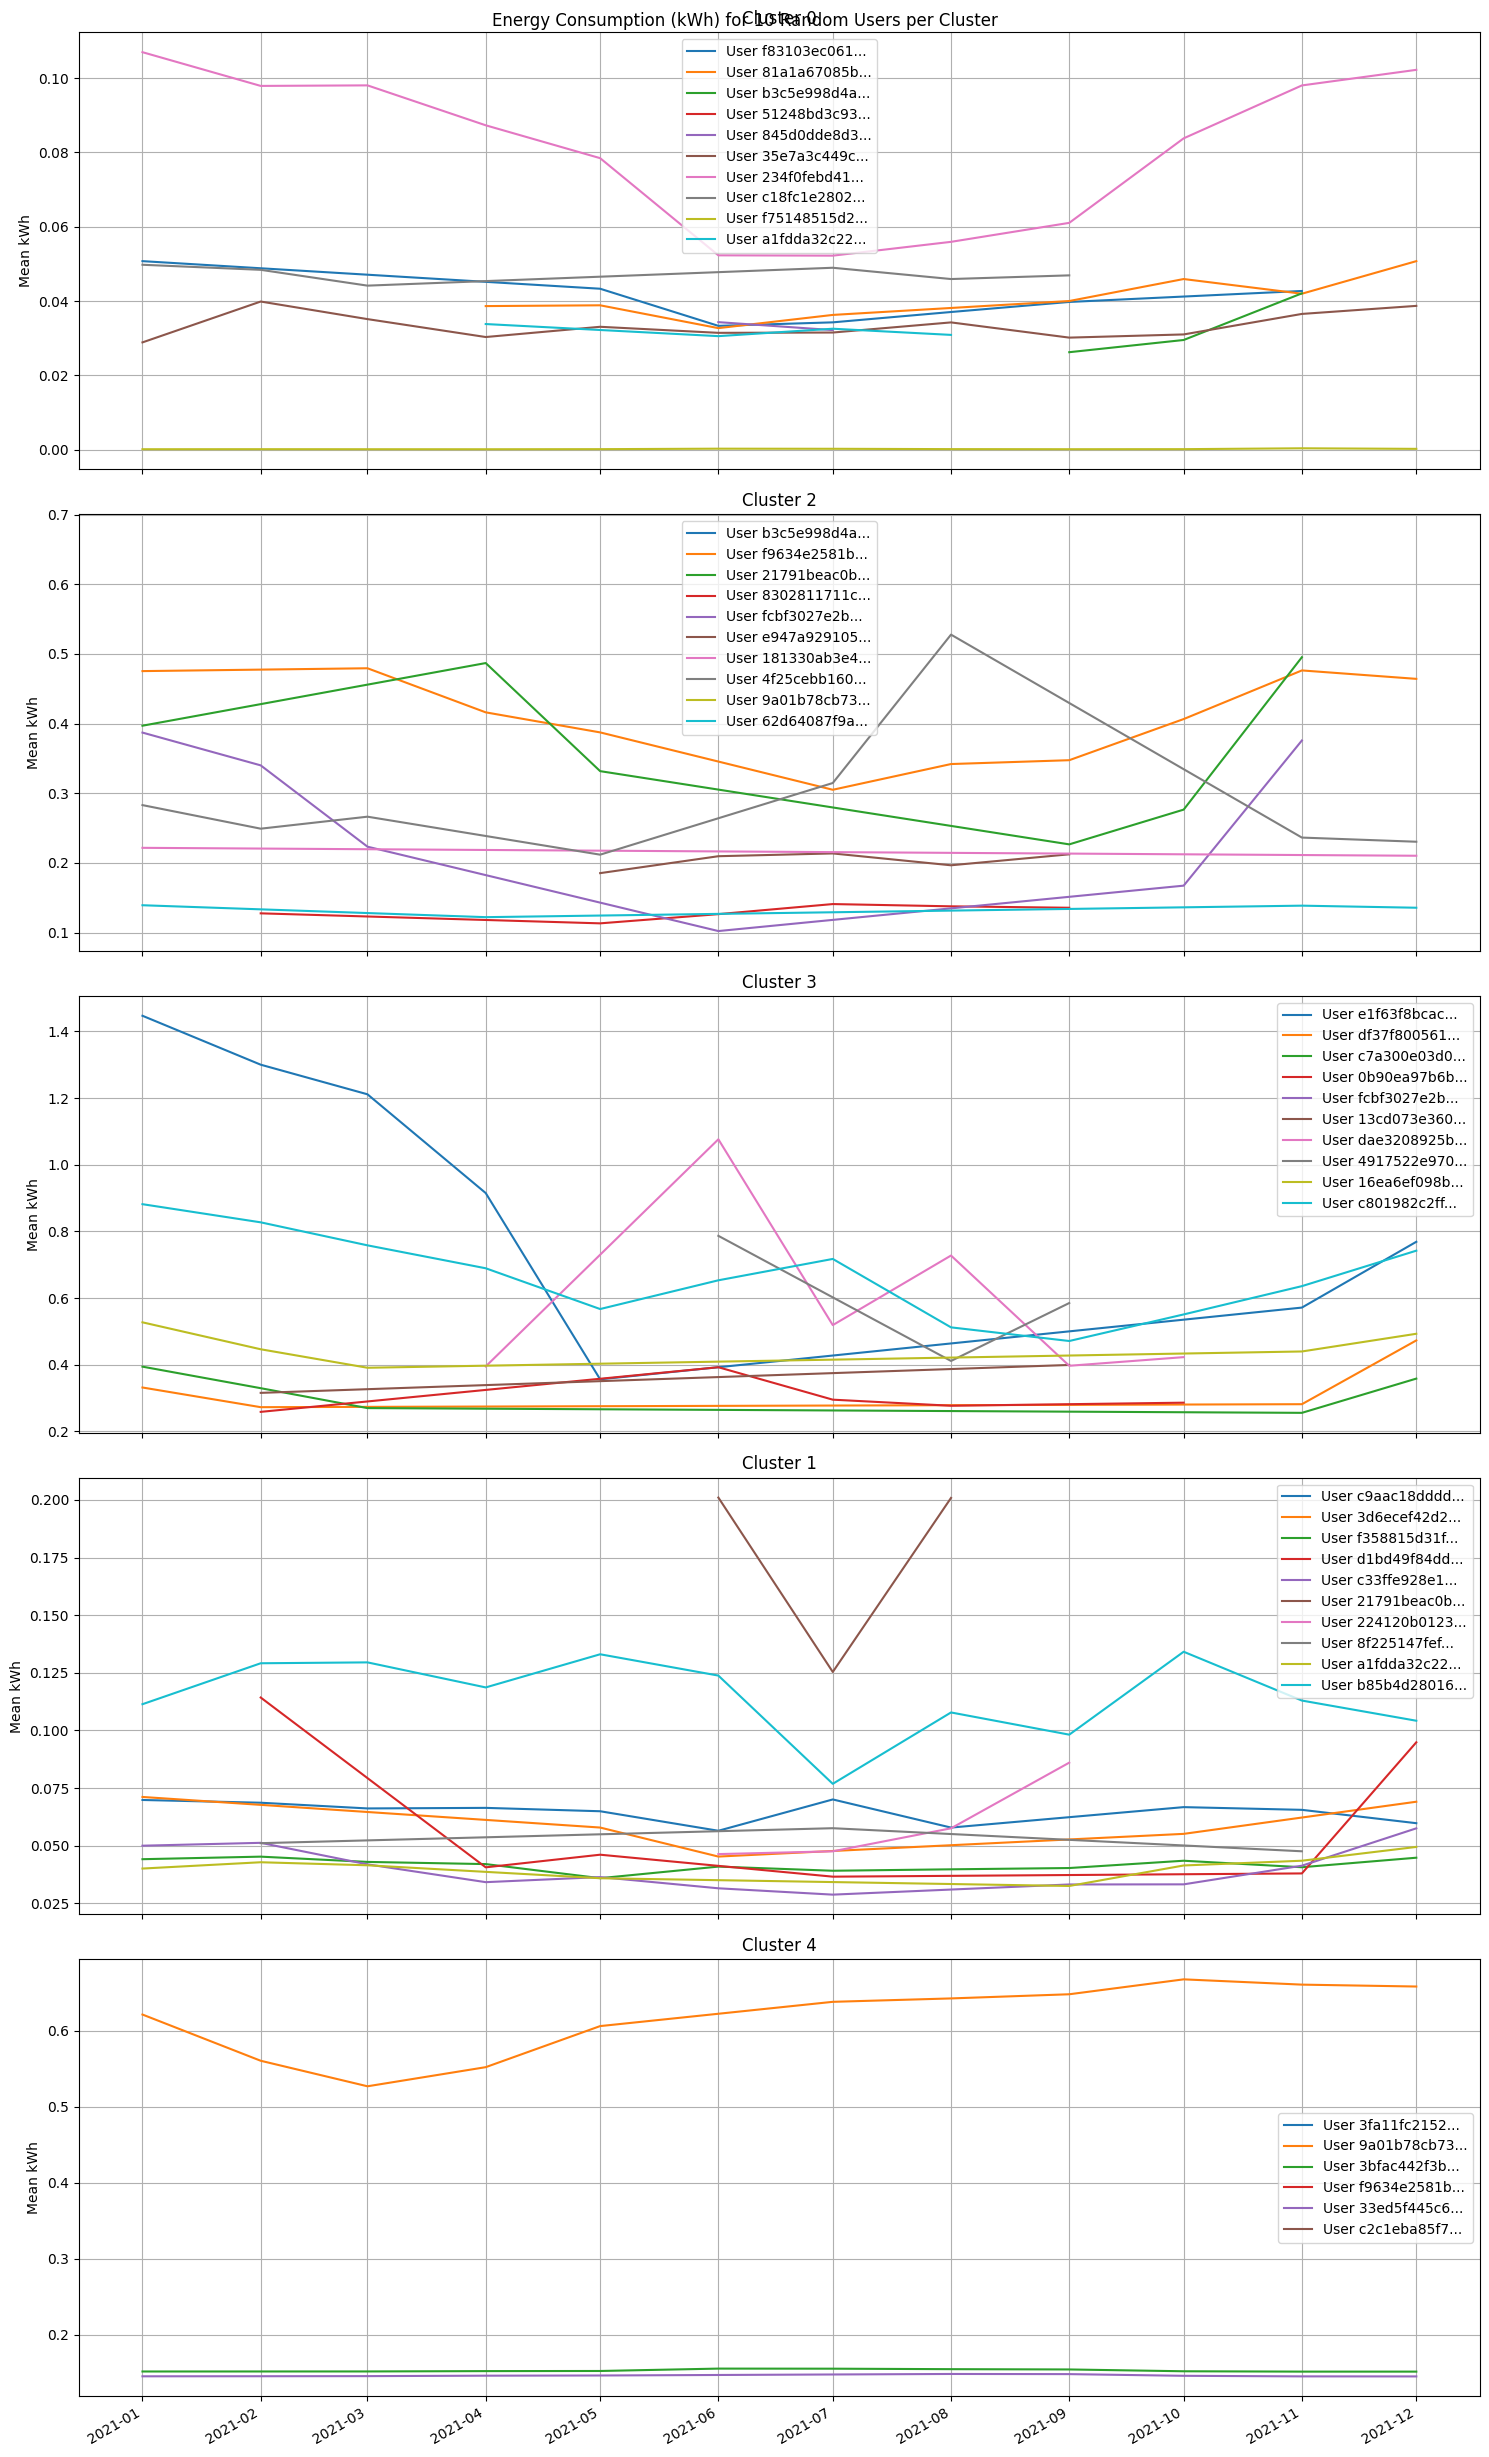

In [11]:
first_x_users_in_cluster_to_display = 10

df = monthly_features_df
# df['year_month'] = df['year_month'].dt.to_timestamp()
df['cluster'] = df['cluster'].astype(int)
clusters = df['cluster'].unique()

# Set up the plot
fig, axes = plt.subplots(len(clusters), 1, figsize=(15, 5*len(clusters)), sharex=True)
fig.suptitle(f'Energy Consumption (kWh) for {first_x_users_in_cluster_to_display} Random Users per Cluster')

if len(clusters) == 1:
    axes = [axes]

for idx, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = df[df['cluster'] == cluster]
    
    # Get X random user IDs from this cluster
    random_users = np.random.choice(cluster_data['id'].unique(), min(first_x_users_in_cluster_to_display, len(cluster_data['id'].unique())), replace=False)
    
    # Plot data for each random user
    for user in random_users:
        user_data = cluster_data[cluster_data['id'] == user]
        user_data = user_data.sort_values('year_month')
        axes[idx].plot(user_data['year_month'], user_data['value_kwh_mean'], label=f'User {user[:first_x_users_in_cluster_to_display+1]}...')
    
    axes[idx].set_title(f'Cluster {cluster}')
    axes[idx].set_ylabel('Mean kWh')
    axes[idx].legend()
    axes[idx].grid(True)

# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()
plt.show()